# "Cross-Validation with fastai v2"
> "This notebook contains the training process of Convolutional Neural Networks with Cross Validation using a subsection of the [MAMMOSET](https://bitbucket.org/gbdi/mammoset/src/master/) dataset"

- toc: true
- branch: master
- badges: true
- author: João Marcelo Tozato
- categories: [fastpages, jupyter, fastai, DDSM, mass]

In [ ]:
from fastai2.vision.all import *
path = Path('./DDSM_NOBARS/'); path.ls()

### DDSM Mass Dataset and splits

In [2]:
batch_tfms = [IntToFloatTensor(),
              *aug_transforms(size=224, max_warp=0, min_scale=0.75),
              Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor(), Resize(460)]
bs=64

In [3]:
train_imgs = get_image_files(path/'train')
tst_imgs = get_image_files(path/'test')

In [4]:
random.shuffle(train_imgs)

In [5]:
len(train_imgs)

1239

Here we do an 80/20 split

In [9]:
start_val = len(train_imgs) - int(len(train_imgs)*.2) # last 20% validation

In [10]:
idxs = list(range(start_val, len(train_imgs)))

In [11]:
splits = IndexSplitter(idxs)

In [12]:
split = splits(train_imgs)

In [13]:
len(train_imgs)

1239

In [14]:
split_list = [split[0], split[1]]

In [15]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

We have 992 training images, 247 validation images and 142 test images

In [16]:
split_list

[(#992) [0,1,2,3,4,5,6,7,8,9...],
 (#247) [992,993,994,995,996,997,998,999,1000,1001...],
 (#142) [1239,1240,1241,1242,1243,1244,1245,1246,1247,1248...]]

In [17]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

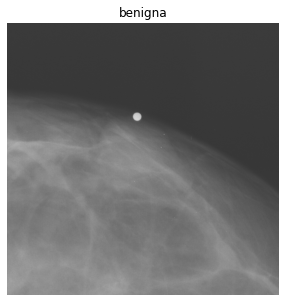

In [18]:
show_at(dsrc.train, 3)

In [19]:
dsrc.n_subsets

3

In [20]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

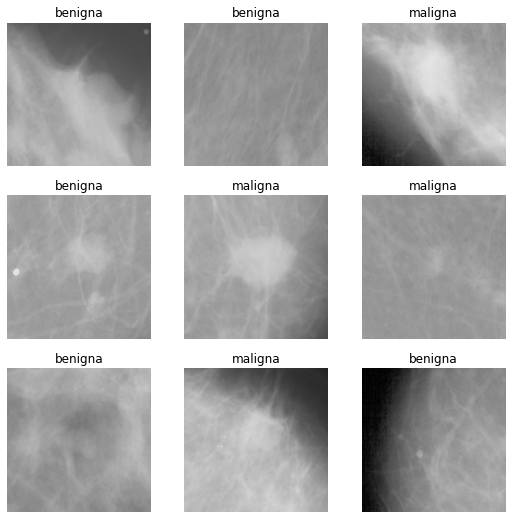

In [21]:
dls.show_batch()

### Baseline

In [22]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.255100,1.078973,0.546559,00:06
1,1.164489,1.024763,0.562753,00:05
2,1.068163,0.723718,0.684211,00:06
3,1.019540,0.661954,0.700405,00:06
4,0.953290,0.638257,0.712551,00:06


/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


The baseline model got and accuracy of ~61.27% on the test set.

In [23]:
learn.validate(ds_idx=2)[1]

0.6126760840415955

### Cross Validation

In [24]:
from sklearn.model_selection import StratifiedKFold

In [25]:
train_labels = L()
for i in range(len(dsrc.train)):
    train_labels.append(dsrc.train[i][1])
for i in range(len(dsrc.valid)):
    train_labels.append(dsrc.valid[i][1])
train_labels

(#1239) [TensorCategory(1),TensorCategory(1),TensorCategory(1),TensorCategory(0),TensorCategory(0),TensorCategory(0),TensorCategory(1),TensorCategory(0),TensorCategory(1),TensorCategory(1)...]

In [27]:
random.shuffle(train_imgs)

Our training loop will include the same process we've done above on the `DDSM Mass Dataset and splits` section. That is, we will be splitting the training dataset 10 times and training a model on each of these datasets, after the training process is done we take the average of all the predictions for the test set on each split.

In [28]:
#collapse-hide
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
for _, val_idx in skf.split(np.array(train_imgs), train_labels):
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
    dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                  splits=split_list)
    dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)
    learn = cnn_learner(dls, resnet34, pretrained=True, metrics=accuracy).to_fp16()
    learn.fit_one_cycle(5)
    val_pct.append(learn.validate()[1])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,1.136114,0.953437,0.491935,00:06
1,1.066459,1.036575,0.548387,00:05
2,1.011496,0.784486,0.669355,00:05
3,0.968455,0.714560,0.669355,00:05
4,0.928864,0.756449,0.653226,00:06


/home/jmtzt/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,accuracy,time
0,1.343768,0.991764,0.572581,00:05
1,1.203773,0.972596,0.629032,00:05
2,1.097104,0.879680,0.669355,00:06
3,1.015946,0.630741,0.725806,00:06
4,0.939799,0.595138,0.733871,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.401825,0.975166,0.564516,00:05
1,1.211842,1.150666,0.620968,00:05
2,1.106027,0.824127,0.693548,00:05
3,1.005552,0.643290,0.717742,00:05
4,0.949984,0.611353,0.685484,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.285932,1.116190,0.516129,00:05
1,1.176994,0.952720,0.629032,00:05
2,1.059058,0.891377,0.637097,00:06
3,0.987869,0.730751,0.701613,00:06
4,0.942768,0.642452,0.701613,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.271043,0.824401,0.540323,00:05
1,1.188266,1.026128,0.564516,00:05
2,1.083751,0.844839,0.596774,00:05
3,1.015182,0.688445,0.669355,00:06
4,0.949915,0.696868,0.677419,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.252791,0.952793,0.475806,00:05
1,1.091202,0.878849,0.596774,00:05
2,1.030211,0.801414,0.661290,00:06
3,0.971240,0.716754,0.693548,00:05
4,0.923688,0.656634,0.717742,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.171420,0.854203,0.548387,00:05
1,1.043760,0.852307,0.637097,00:06
2,0.946355,0.857245,0.604839,00:05
3,0.898549,0.815291,0.645161,00:05
4,0.841311,0.815915,0.677419,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.348083,0.972769,0.564516,00:05
1,1.179842,0.945408,0.620968,00:05
2,1.112100,0.715282,0.653226,00:05
3,1.044266,0.638139,0.717742,00:05
4,0.984065,0.619281,0.717742,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.230497,0.981037,0.500000,00:06
1,1.114652,0.823075,0.653226,00:06
2,1.009943,0.715533,0.653226,00:06
3,0.941501,0.730544,0.629032,00:06
4,0.899372,0.703373,0.629032,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.403852,0.920186,0.552846,00:06
1,1.189877,0.931247,0.658537,00:05
2,1.064095,0.824453,0.658537,00:05
3,1.018285,0.733249,0.642276,00:05
4,0.971781,0.751345,0.650406,00:05


Now how do we combine all our predictions? We sum them all together then divide by our total

In [29]:
tst_preds_copy = tst_preds.copy()

In [30]:
accuracy(tst_preds_copy[0], b)

tensor(0.6268)

Now let's add them all together and get an average prediction

In [39]:
for i in tst_preds_copy:
    print(accuracy(i, b))

tensor(0.6479)
tensor(0.5986)
tensor(0.6268)
tensor(0.6127)
tensor(0.6408)
tensor(0.6127)
tensor(0.6549)
tensor(0.6338)
tensor(0.6831)
tensor(0.6408)


In [40]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
    hat += pred

In [41]:
hat[:5]

tensor([[3.7651, 6.2349],
        [9.1702, 0.8298],
        [8.2053, 1.7947],
        [9.8177, 0.1823],
        [4.1707, 5.8293]])

In [42]:
len(hat)

142

In [43]:
hat /= len(tst_preds)

This accuracy is the average of all the predictions of the models trained on the splits. ~~65.49%

In [44]:
accuracy(hat, b)

tensor(0.6549)

This is the process we'll be using to conduct our experiments on several CNN models.